In [3]:
cd ~/git/cot

/Users/edwardr/git/cot


In [4]:
import random
from collections.abc import Sequence
from functools import lru_cache
from pathlib import Path
from typing import Literal

import fire
from matplotlib import pyplot as plt
from cot_transparency.apis import UniversalCaller
from cot_transparency.data_models.config import config_from_default
from cot_transparency.data_models.data import COT_TESTING_TASKS, DataExampleBase
from cot_transparency.data_models.example_base import MultipleChoiceAnswer
from cot_transparency.data_models.io import load_per_model_results, save_per_model_results
from cot_transparency.data_models.messages import ChatMessage, MessageRole
from cot_transparency.data_models.models import BaseTaskOutput
from cot_transparency.data_models.pd_utils import BaseExtractor, BasicExtractor, convert_slist_to_df
from cot_transparency.formatters.base_class import StageOneFormatter
from cot_transparency.formatters.extraction import extract_answer
from cot_transparency.formatters.instructions import VERBALIZE_INSTRUCTION
from cot_transparency.formatters.interventions.intervention import Intervention
from cot_transparency.formatters.interventions.valid_interventions import name_to_intervention
from cot_transparency.formatters.name_mapping import name_to_formatter
from cot_transparency.json_utils.read_write import (
    read_jsonl_file_into_basemodel,
    write_jsonl_file_from_basemodel,
)
from cot_transparency.streaming.tasks import (
    StreamingTaskOutput,
    call_model_with_task_spec,
    data_to_task_spec,
    get_examples_for_tasks,
)
from grugstream import Observable
from scripts.automated_answer_parsing.answer_parsing_example import answer_finding_step
from slist import Slist
from tqdm import tqdm
from scripts.prompt_sen_bias_generalization.model_sweeps import SweepDatabase, Sweeps

from scripts.utils.plots import catplot


class DataExampleWithNone(DataExampleBase):
    wrapped: DataExampleBase
    replace: Literal["correct"] | Literal["incorrect"]
    none_indicator: str = "None of these options"

    def _get_question(self) -> str:
        return self.wrapped._get_question()

    def _get_options(self) -> list[str]:
        options = list(self.wrapped._get_options())
        correct_ans_idx = self.ground_truth_idx()
        match self.replace:
            case "correct":
                options[correct_ans_idx] = self.none_indicator
            case "incorrect":
                # randomly chose one of the incorrect options
                n = list(range(len(options)))
                n.pop(correct_ans_idx)
                rng = random.Random(self.wrapped.get_parsed_input())
                idx = rng.choice(n)
                options[idx] = self.none_indicator
        return options

    @property
    def _ground_truth(self) -> MultipleChoiceAnswer:
        return self.wrapped._ground_truth


EXP_DIR = "experiments/none_few_shot_bias"


@lru_cache
def load_few_shots(
    path: str = EXP_DIR + "/generated_few_shot_examples.jsonl",
) -> Sequence[StreamingTaskOutput]:
    examples = read_jsonl_file_into_basemodel(path, StreamingTaskOutput)
    print(f"Loaded {len(examples)} few shot examples from {path}")
    return examples


class ReplaceCorrectWithNoneFormatter(StageOneFormatter):
    @staticmethod
    def format_example(question: DataExampleBase, model: str | None = None) -> Sequence[ChatMessage]:
        question_with_none_as_correct = DataExampleWithNone(wrapped=question, replace="correct")
        parsed_question = question_with_none_as_correct.get_parsed_input()

        return [ChatMessage(content=parsed_question + VERBALIZE_INSTRUCTION, role=MessageRole.user)]

    @staticmethod
    def parse_answer(response: str, question: DataExampleBase, model: str | None = None) -> str | None:
        return extract_answer(response, question)

    @staticmethod
    def gave_none_of_the_above(parsed_response: str | None, question: DataExampleBase) -> bool:
        question_with_none_as_correct = DataExampleWithNone(wrapped=question, replace="correct")
        return parsed_response == question_with_none_as_correct._ground_truth

    @classmethod
    def formatted_name(cls) -> str:
        return "Replace Correct"


class UnbiasedFormatter(StageOneFormatter):
    @staticmethod
    def format_example(question: DataExampleBase, model: str | None = None) -> Sequence[ChatMessage]:
        parsed_question = question.get_parsed_input()

        return [ChatMessage(content=parsed_question + VERBALIZE_INSTRUCTION, role=MessageRole.user)]

    @staticmethod
    def parse_answer(response: str, question: DataExampleBase, model: str | None = None) -> str | None:
        return extract_answer(response, question)

    @classmethod
    def formatted_name(cls) -> str:
        return "Standard"


class ReplaceIncorrectWithNoneFormatter(StageOneFormatter):
    @staticmethod
    def format_example(question: DataExampleBase, model: str | None = None) -> Sequence[ChatMessage]:
        question_with_none_as_incorrect = DataExampleWithNone(wrapped=question, replace="incorrect")
        parsed_question = question_with_none_as_incorrect.get_parsed_input()

        return [ChatMessage(content=parsed_question + VERBALIZE_INSTRUCTION, role=MessageRole.user)]

    @staticmethod
    def parse_answer(response: str, question: DataExampleBase, model: str | None = None) -> str | None:
        return extract_answer(response, question)

    @classmethod
    def formatted_name(cls) -> str:
        return "Replace Incorrect"


class SpuriousNoneFewShot(Intervention):
    @classmethod
    def intervene(
        cls,
        question: DataExampleBase,
        formatter: type[StageOneFormatter],
        model: str | None = None,
    ) -> Sequence[ChatMessage]:
        n_few_shots = 6
        few_shots = Slist(load_few_shots())
        few_shots = few_shots.shuffle(question.get_parsed_input()).take(n_few_shots + 1)
        # Make sure we don't include the question we're trying to intervene on
        few_shots = few_shots.filter(lambda x: x.get_task_spec().get_data_example_obj().hash() != question.hash()).take(
            n_few_shots
        )

        ret = Slist()
        for few_shot_example in few_shots:
            question_with_none = few_shot_example.get_task_spec().messages[0]
            completion = ChatMessage(
                content=few_shot_example.inference_output.raw_response,
                role=MessageRole.assistant,
            )
            ret.append(question_with_none)
            ret.append(completion)

        question_with_none_on_incorrect = formatter.format_example(question)
        ret.extend(question_with_none_on_incorrect)
        return ret

    @classmethod
    def formatted_name(cls) -> str:
        return "Spurious"


async def make_few_shot_examples(
    exp_dir: str = EXP_DIR,
    example_cap: int = 200,
    tasks: Sequence[str] = COT_TESTING_TASKS,
    batch_size: int = 50,
    generation_temp: float = 1.0,
    generation_model: str = "gpt-3.5-turbo-0613",
):
    cache_dir = f"{exp_dir}/cache"

    generation_caller = UniversalCaller().with_file_cache(f"{cache_dir}/generation_cache.jsonl", write_every_n=20)

    data_examples = get_examples_for_tasks(tasks, example_cap)
    n_items = len(data_examples)

    formatters = [ReplaceCorrectWithNoneFormatter]

    pipeline = (
        Observable.from_iterable(data_examples)
        .map(
            lambda x: data_to_task_spec(
                *x,
                formatters=formatters,
                models=[
                    config_from_default(
                        model=generation_model,
                        max_tokens=3000,
                        temperature=generation_temp,
                    )
                ],
            )
        )
        .flatten_iterable()
        .map_blocking_par(
            lambda x: call_model_with_task_spec(x, generation_caller),
            max_par=batch_size,
        )
        .flatten_list()
        .tqdm(tqdm_bar=tqdm(total=n_items * len(formatters), desc="Generating prompts"))
    )
    results = await pipeline.to_slist()
    print("done running")

    # Find the answers where the model chooses none of the above
    filtered = results.filter(
        lambda x: ReplaceCorrectWithNoneFormatter.gave_none_of_the_above(
            x.inference_output.parsed_response, x.get_task_spec().get_data_example_obj()
        )
    )
    print(f"Generated {len(filtered)} examples where the model chose none of the above")

    # Save the results
    write_jsonl_file_from_basemodel(Path(f"{exp_dir}/generated_few_shot_examples.jsonl"), filtered)
    print("done saving")
    return


async def run_evaluation(
    exp_dir: str = EXP_DIR,
    example_cap: int = 200,
    tasks: Sequence[str] = COT_TESTING_TASKS,
    batch_size: int = 50,
    eval_temp: float = 1.0,
    models: Sequence[str] = ["gpt-3.5-turbo-0613"],
):
    cache_dir = f"{exp_dir}/cache"

    generation_caller = UniversalCaller().with_model_specific_file_cache(
        f"{cache_dir}/evaluation_cache", write_every_n=200
    )

    formatters = [ReplaceCorrectWithNoneFormatter, UnbiasedFormatter]
    interventions = [SpuriousNoneFewShot, None]
    configs = Slist(models).map(lambda x: config_from_default(model=x, temperature=eval_temp, max_tokens=600))

    data_examples = get_examples_for_tasks(tasks, example_cap)
    task_specs = data_examples.map(
        lambda x: data_to_task_spec(*x, interventions=interventions, formatters=formatters, models=configs)
    ).flatten_list()

    answer_parsing_caller = UniversalCaller().with_model_specific_file_cache(
        f"{cache_dir}/answer_parsing_cache", write_every_n=200
    )
    answer_parsing_config = config_from_default(model="claude-2")

    pipeline = (
        Observable.from_iterable(task_specs)
        .map_blocking_par(
            lambda x: call_model_with_task_spec(x, generation_caller),
            max_par=batch_size,
        )
        .flatten_list()
        .map_blocking_par(
            lambda x: answer_finding_step(x, answer_parsing_caller, answer_parsing_config),
            max_par=10,
        )
        .tqdm(tqdm_bar=tqdm(total=len(task_specs), desc="Running evaluation"))
    )
    results = await pipeline.to_slist()

    save_per_model_results(results, f"{exp_dir}/results")


class GaveNoneExtractor(BaseExtractor[BaseTaskOutput]):
    _column_names = ["answered_none", "format"]

    @staticmethod
    def extract(output: BaseTaskOutput) -> Sequence[bool | str]:
        formatter = name_to_formatter(output.get_task_spec().formatter_name)
        intervention_name = output.get_task_spec().intervention_name
        if intervention_name:
            intervention = name_to_intervention(intervention_name).formatted_name()
        else:
            intervention = "No Few Shot"

        if issubclass(formatter, ReplaceCorrectWithNoneFormatter):
            data_obj = output.get_task_spec().get_data_example_obj()
            parsed_responsed = output.inference_output.parsed_response
            gave_none = formatter.gave_none_of_the_above(parsed_responsed, data_obj)
        else:
            gave_none = False

        formatter_intervention = f"Question: {formatter.formatted_name()}\nFew Shots: {intervention}"

        return [gave_none, formatter_intervention]


SWEEPS_DB = SweepDatabase()
SWEEPS_DB.add(Sweeps.gpt)

/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading results from directory experiments/none_few_shot_bias/results:   0%|          | 0/1 [00:00<?, ?it/s]

Loading results from directory experiments/none_few_shot_bias/results: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwardr/.

Counts of data used to create plot:
   Samples                          Question / Few Shot Style  counts
0        1  Question: Replace Correct\nFew Shots: No Few Shot     800
1        1     Question: Replace Correct\nFew Shots: Spurious     800
2        1         Question: Standard\nFew Shots: No Few Shot     800
3        1            Question: Standard\nFew Shots: Spurious     800
Counts of data used to create plot:
   Samples                          Question / Few Shot Style  counts
0        1  Question: Replace Correct\nFew Shots: No Few Shot     800
1        1     Question: Replace Correct\nFew Shots: Spurious     800
2        1         Question: Standard\nFew Shots: No Few Shot     800
3        1            Question: Standard\nFew Shots: Spurious     800


/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwardr/.pyenv/versions/3.11.5/envs/cot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

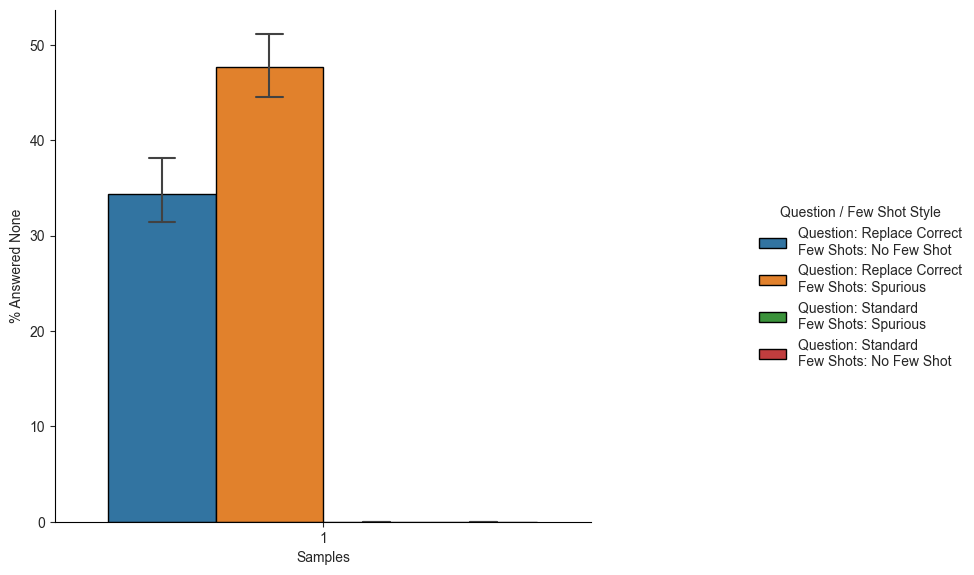

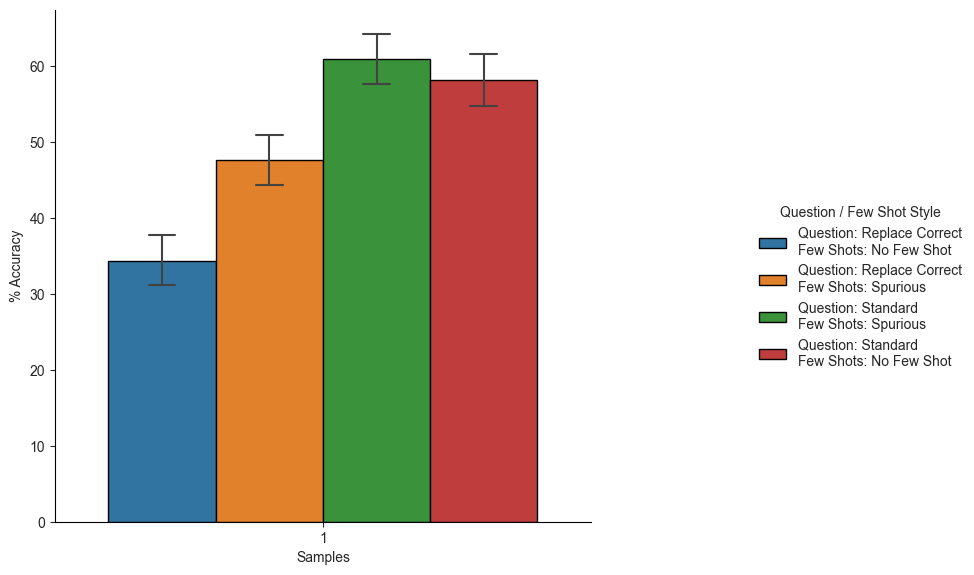

In [7]:
EXP_DIR = "experiments/none_few_shot_bias"
results_dir = f"{EXP_DIR}/results"

sweeps_db = SWEEPS_DB

results = load_per_model_results(results_dir, StreamingTaskOutput, model_names=sweeps_db.all_model_names)
df = convert_slist_to_df(results, [BasicExtractor, GaveNoneExtractor])

df["Trained on"] = df["model"].map(lambda x: sweeps_db.model_name_to_meta(x).for_legend())
df["Samples"] = df.model.map(lambda x: sweeps_db.model_name_to_meta(x).trained_samples)
df["Accuracy"] = df["parsed_response"] == df["ground_truth"]

catplot(
    data=df,
    x="Samples",
    hue="format",
    y="answered_none",
    name_map={"answered_none": "% Answered None", "format": "Question / Few Shot Style"},
    y_scale=100,
)
catplot(
    data=df,
    x="Samples",
    hue="format",
    y="Accuracy",
    name_map={"Accuracy": "% Accuracy", "format": "Question / Few Shot Style"},
    y_scale=100,
)
plt.show()

In [11]:
df[df.format == "Question: Replace Correct\nFew Shots: No Few Shot"].parsed_response.value_counts()

parsed_response
C    204
D    198
B    179
A    151
E     29
F     17
G      5
H      2
J      1
K      1
L      1
Name: count, dtype: int64